In [713]:
import numpy as np
import pandas as pd
import sklearn as sk
from matplotlib import pyplot as plt
import seaborn as sns
from dataclasses import dataclass

In [714]:
seed = 89

In [715]:
df = pd.read_csv('data.csv')
df.drop_duplicates(inplace=True)
df.drop(columns=['ID', 'income (USD)'], inplace=True)
df.reset_index(drop=True)
df.sample(5)

,age,gender,bmi,children,smoker,region,status,work_sector,physical_activity,stress_level,sleep_quality,charges (USD)
100,38.0,male,21.120,3,no,southeast,Single,Construction,Very Active,7.8,Fair,6652.52880
1955,26.0,male,NaN,1,no,southwest,Single,Education,Lightly Active,5.8,Good,2904.08800
2034,20.0,male,30.685,0,yes,northeast,Married,IT,Sedentary,8.5,Fair,33475.81715
2928,27.0,male,28.500,0,yes,northwest,Married,Retail Management,Lightly Active,4.0,Good,18310.74200
2144,57.0,male,28.100,0,no,southwest,Single,Construction,Moderately Active,5.5,Good,10965.44600


In [716]:
df.describe()

,age,bmi,children,stress_level,charges (USD)
count,3090.000000,3059.000000,3090.000000,3090.000000,3067.000000
mean,39.090493,32.164780,1.119094,6.413689,13488.414417
std,14.139518,99.455521,1.208068,1.722001,12091.943251
min,-8.000000,-989.915959,-3.000000,0.000000,1000.000000
25%,27.000000,26.315000,0.000000,5.200000,4719.524050
50%,39.000000,30.495000,1.000000,6.400000,9644.252500
75%,51.000000,34.800000,2.000000,7.600000,17870.867613
max,88.336729,5424.864393,5.000000,10.000000,63770.428010


In [717]:
print(f'smoker: {df.smoker.unique()}')
print(f'gender: {df.gender.unique()}')
print(f'region: {df.region.unique()}')
print(f'status: {df.status.unique()}')
print(f'work sector: {df.work_sector.unique()}')
print(f'sleep quality: {df.sleep_quality.unique()}')
print(f'physical activity: {df.physical_activity.unique()}')

smoker: ['no' 'yes' '-' 'DFH']
gender: ['female' 'male']
region: ['southwest' 'northwest' 'southeast' 'northeast']
status: ['Single' 'Engaged' 'Married' 'Single-Parent' 'CDE' 'ABC' nan]
work sector: ['Education' 'IT Support' 'Transportation' 'Hospitality' 'Unemployed'
 'Healthcare Support' 'Retail' 'Entrepreneur' 'Finance' 'Construction'
 'Retail Management' 'Healthcare' 'Law' 'Management' 'Self-Employed' 'IT'
 nan 'Engineering' 'Wizardry' 'Interdimensional Trade']
sleep quality: ['Fair' 'Poor' 'Good' 'Excellent' 'CDE']
physical activity: ['Lightly Active' 'Sedentary' 'Very Active' 'Moderately Active' nan
 'video-gamer']


In [718]:
mask = (df['status'] == 'ABC') | (df['status'] == 'CDE') | (df['sleep_quality'] == 'CDE') | (
        df['physical_activity'] == 'video-gamer')
df[mask]
# drop those 3 as they make no sense and ~0.1% of dataset
# all of them have 2 'corrupted' features

,age,gender,bmi,children,smoker,region,status,work_sector,physical_activity,stress_level,sleep_quality,charges (USD)
36,32.027049,male,32.316381,-3,no,southeast,Married,Construction,Moderately Active,5.3,CDE,10412.900531
573,22.632769,male,-989.915959,0,no,northwest,CDE,Healthcare Support,Lightly Active,2.0,Excellent,22486.448061
639,44.676202,male,27.186491,0,yes,southeast,ABC,Wizardry,video-gamer,4.9,Good,14737.870783


also 'Wizardry' and 'Interdimensional Trade' are strange, I'll drop them to nan and use as Unknown

In [719]:
df.work_sector = df.work_sector.replace(['Wizardry', 'Interdimensional Trade'], np.nan)

In [720]:
df = df[~mask]
df.reset_index(drop=True)

,age,gender,bmi,children,smoker,region,status,work_sector,physical_activity,stress_level,sleep_quality,charges (USD)
0,45.0,female,25.700,3,no,southwest,Single,Education,Lightly Active,6.9,Fair,9101.79800
1,32.0,male,28.120,4,yes,northwest,Engaged,IT Support,Sedentary,6.9,Poor,21472.47880
2,41.0,female,37.100,2,-,southwest,Single,Transportation,Very Active,5.9,Fair,7371.77200
3,26.0,male,31.065,0,no,northwest,Single,Education,Sedentary,5.9,Fair,2699.56835
4,23.0,female,34.960,3,no,northwest,Married,Hospitality,Sedentary,8.6,Good,4466.62140
...,...,...,...,...,...,...,...,...,...,...,...,...
3082,54.0,male,34.210,2,yes,southeast,Married,Finance,Lightly Active,9.2,Poor,44260.74990
3083,18.0,female,31.350,4,no,northeast,Single,Retail,Sedentary,10.0,Poor,4561.18850
3084,39.0,female,23.870,5,no,southeast,Single,Transportation,Lightly Active,5.8,Good,8582.30230
3085,58.0,male,25.175,0,no,northeast,Single,Education,Lightly Active,4.7,Poor,11931.12525


let's encode features:
- gender to boolean 'is_male'
- smoker oneHot (smoking, not smoking, unknown)
- region oneHot
- status oneHot (later after imputation)
- work_sector oneHot (later after imputation)
- sleep_quality numerical (as it's ordinal Poor -> Excellent)
- physical_activity numerical (as it's ordinal Sedentary -> Very Active)

In [721]:
print(f'{(df.children < 0).sum()} negative children rows')
df[(df.age < 18)]

1 negative children rows


,age,gender,bmi,children,smoker,region,status,work_sector,physical_activity,stress_level,sleep_quality,charges (USD)
87,15.123557,female,30.360872,0,no,southeast,Single,Retail,Lightly Active,6.3,Poor,12864.070934
229,15.727649,female,41.854735,3,no,southeast,Married,IT,Moderately Active,4.5,Poor,46680.037223
306,15.168302,female,33.939556,0,yes,southwest,Engaged,Retail Management,Moderately Active,6.7,Fair,2495.923471
450,6.190668,female,22.324037,1,no,southeast,Married,Hospitality,Sedentary,1.8,Excellent,5679.525258
454,13.329776,male,31.931234,3,yes,northwest,Single,Healthcare,Sedentary,7.3,Poor,29890.117369
482,2.374126,female,26.686038,1,no,northwest,Single,Finance,Moderately Active,6.5,Fair,27999.218508
695,2.879041,female,28.338212,2,yes,southwest,Single,Finance,Lightly Active,9.1,Poor,37556.610697
789,15.834161,male,38.075766,1,no,northwest,Single,Healthcare,Lightly Active,8.1,Poor,17332.663693
871,12.526339,female,26.256683,2,no,northwest,Married,Management,Moderately Active,4.3,Fair,3256.099146
882,10.592705,male,31.844211,0,yes,northeast,Married,Hospitality,Lightly Active,6.2,Poor,23619.942885


only one with negative children, let's just set it to 0

those values of age make no sense (married or with children at <18...)

let's drop those with nan, and later impute them

In [722]:
df['smoker'] = df['smoker'].str.strip().str.lower()
df['smoking'] = df['smoker'].eq('yes').astype('float')
df['not_smoking'] = df['smoker'].eq('no').astype('float')
df = df.drop(columns=['smoker'])
df.children = df.children.apply(lambda x: max(x, 0)).astype(float)
df['is_male'] = df.gender.apply(lambda x: 1 if x == 'male' else 0).astype(float)
df.drop(columns=['gender'], inplace=True)
df = pd.get_dummies(df, columns=['region'], drop_first=True, dtype=float)
# df.sleep_quality = df.sleep_quality.apply(lambda x:
#                                           {
#                                               'Poor': 0,
#                                               'Fair': 1,
#                                               'Good': 2,
#                                               'Excellent': 3
#                                           }[x]).astype(float)
# df.physical_activity = df.physical_activity.apply(lambda x:
#                                                   {
#                                                       'Sedentary': 0,
#                                                       'Lightly Active': 1,
#                                                       'Moderately Active': 2,
#                                                       'Very Active': 3
#                                                   }.get(x, np.nan)).astype(float)
df.age = df.age.where(df.age >= 18)
df.sample(10)

,age,bmi,children,status,work_sector,physical_activity,stress_level,sleep_quality,charges (USD),smoking,not_smoking,is_male,region_northwest,region_southeast,region_southwest
102,56.0,33.630,0.0,Married,Management,Lightly Active,5.4,Poor,43921.18370,1.0,0.0,1.0,1.0,0.0,0.0
1244,36.0,41.895,3.0,Married,Healthcare,Moderately Active,8.7,Poor,43753.33705,1.0,0.0,1.0,0.0,0.0,0.0
1508,45.0,24.310,5.0,Single,Retail,Lightly Active,6.5,Poor,NaN,0.0,1.0,1.0,0.0,1.0,0.0
646,53.0,28.600,3.0,Engaged,Transportation,Very Active,6.7,Good,11253.42100,0.0,1.0,1.0,0.0,0.0,1.0
900,59.0,31.790,2.0,Single,Hospitality,Lightly Active,7.8,Poor,12928.79110,0.0,1.0,1.0,0.0,1.0,0.0
2749,23.0,39.270,2.0,Single,Retail,Lightly Active,5.2,Poor,3500.61230,0.0,1.0,0.0,0.0,1.0,0.0
349,25.0,24.130,0.0,Married,Education,Lightly Active,5.3,Fair,15817.98570,1.0,0.0,1.0,1.0,0.0,0.0
89,35.0,26.125,0.0,Single,Retail,Lightly Active,8.0,Fair,5227.98875,0.0,1.0,0.0,0.0,0.0,0.0
1965,28.0,24.320,1.0,Married,Healthcare,Lightly Active,5.0,Fair,23288.92840,0.0,1.0,0.0,0.0,0.0,0.0
2123,64.0,31.300,2.0,Single-Parent,IT,NaN,8.7,Poor,47291.05500,1.0,0.0,0.0,0.0,0.0,1.0


In [723]:
row_misses = df.isna().mean(axis=1) * 100
(row_misses > 30).sum()  # all rows good

0

now let's check outliers

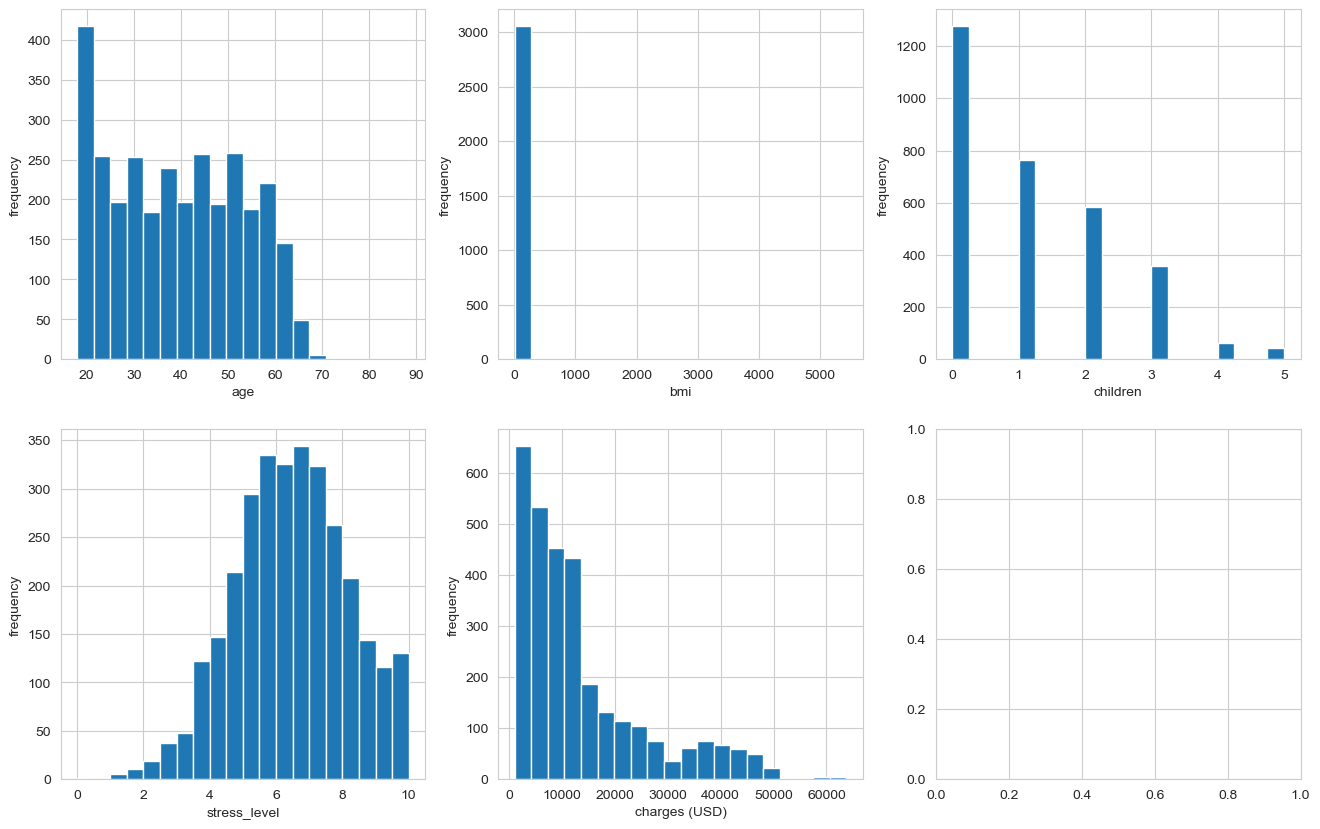

In [724]:
cols = ['age', 'bmi', 'children', 'stress_level', 'charges (USD)']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
for i in range(2):
    for j in range(3):
        if i*3+j == 5:
            continue
        col = cols[i * 3 + j]
        axes[i][j].hist(df[col], bins=20)
        axes[i][j].set_xlabel(col)
        axes[i][j].set_ylabel("frequency")

- bmi clearly have outliers
- charges skewed too, same log there
- age is uniform, so let's bin it

In [725]:
q1 = df.bmi.quantile(0.25)
q3 = df.bmi.quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df.bmi = df.bmi.mask((df.bmi < lower) | (df.bmi > upper))

df['charges (USD)'] = np.log1p(df['charges (USD)'].apply(lambda x: max(x, 0)))

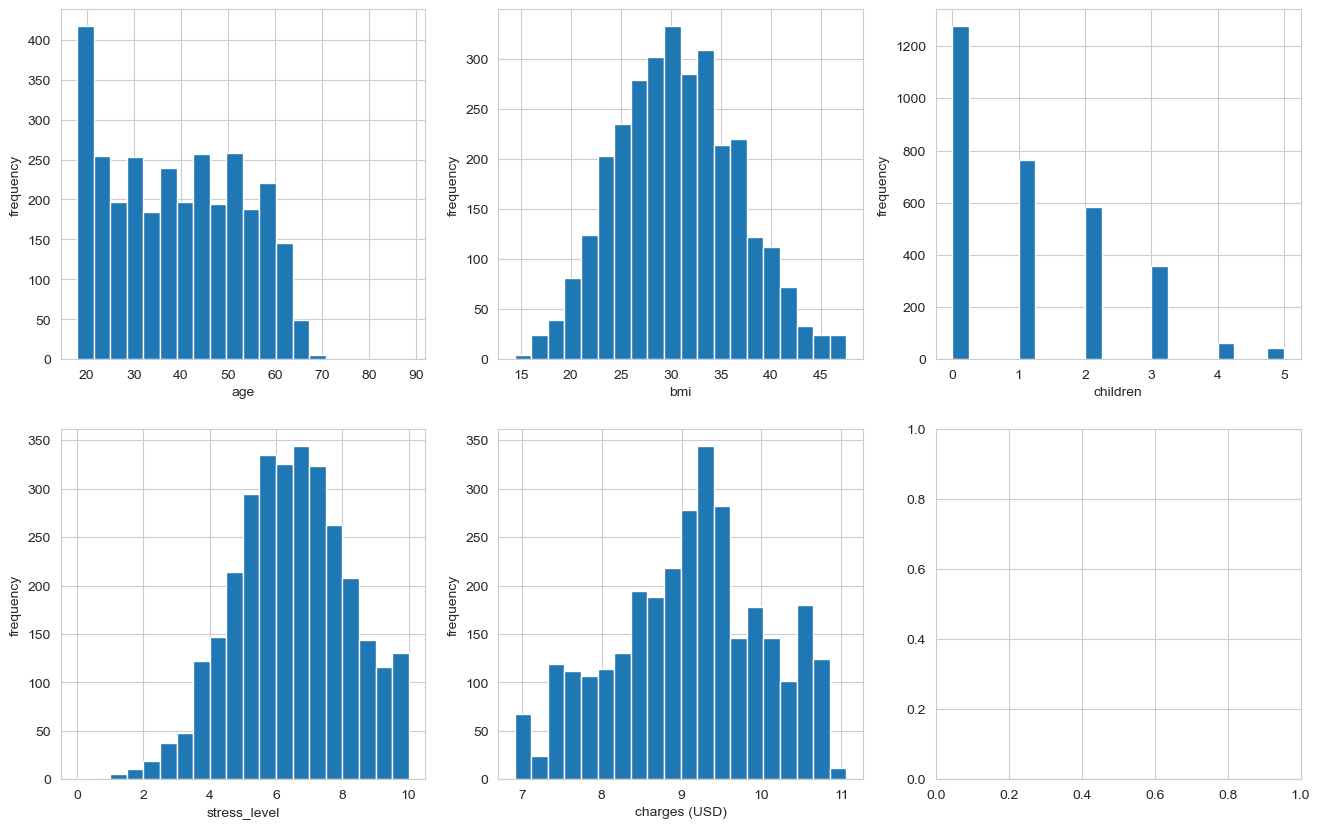

In [726]:
cols = ['age', 'bmi', 'children', 'stress_level', 'charges (USD)']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
for i in range(2):
    for j in range(3):
        if i*3+j  == 5:
            continue
        col = cols[i * 3 + j]
        axes[i][j].hist(df[col], bins=20)
        axes[i][j].set_xlabel(col)
        axes[i][j].set_ylabel("frequency")

corr test

<Axes: >

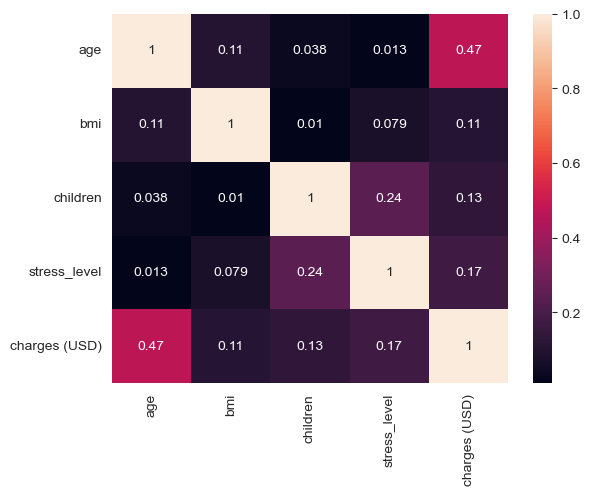

In [727]:
sns.heatmap(df[['age', 'bmi', 'children', 'stress_level', 'charges (USD)']].corr(), annot=True)

age and charges correlates fine, so I'm not going to bin age

### Imputation time

In [728]:
df.isna().sum()

age                  23
bmi                  48
children              0
status                1
work_sector          39
physical_activity    78
stress_level          0
sleep_quality         0
charges (USD)        23
smoking               0
not_smoking           0
is_male               0
region_northwest      0
region_southeast      0
region_southwest      0
dtype: int64

let's drop all rows for charges (as it's target feature)

In [729]:
df = df[~df['charges (USD)'].isna()]

work sector: is something not imputable (as it's a job I will make Missing values 'Unknown')

In [730]:
df.loc[:, 'work_sector'] = df['work_sector'].fillna('Unknown')

age: we are missing only 23 vals, so let's fill with mode

In [731]:
df.loc[:, 'age'] = df['age'].fillna(df['age'].median())

physical activity: we are missing only 79 vals, fill with mode

In [732]:
df.loc[:, 'physical_activity'] = df['physical_activity'].fillna(df['physical_activity'].mode()[0])

status: same

In [733]:
df.loc[:, 'status'] = df['status'].fillna(df['status'].mode()[0])

now we can do imputation:
- split
- scale
- kNN impute

In [734]:
y = df.pop('charges (USD)')
X = df

In [735]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=seed, shuffle=True
)

Now we gonna scale + impute

In [736]:
cols = ['bmi', 'stress_level', 'age', 'children']
standard_scaler = sk.preprocessing.StandardScaler()
X_train[cols] = standard_scaler.fit_transform(X_train[cols])
X_test[cols] = standard_scaler.transform(X_test[cols])

for kNN imputation I'll use Jensen–Shannon divergence formula, to keep distribution alike

In [737]:
def jsd(x, y, bins=30, eps=1e-12):
    hx, e = np.histogram(np.asarray(x, float)[~np.isnan(x)], bins=bins, density=True)
    hy, _ = np.histogram(np.asarray(y, float)[~np.isnan(y)], bins=e, density=True)
    hx = (hx + eps)
    hy = (hy + eps)
    hx /= hx.sum()
    hy /= hy.sum()
    m = 0.5 * (hx + hy)
    js = 0.5 * np.sum(hx * (np.log(hx) - np.log(m))) + 0.5 * np.sum(hy * (np.log(hy) - np.log(m)))
    return float(js / (np.log2(len(hx)) if len(hx) > 1 else 1.0))

In [738]:
def try_knn(n):
    X_train_copy = X_train.copy()
    kNN_imputer = sk.impute.KNNImputer(n_neighbors=n)
    X_train_copy[cols] = kNN_imputer.fit_transform(X_train_copy[cols])
    avg_loss = 0
    for col in cols:
        avg_loss += jsd(X_train[col], X_train_copy[col])
    avg_loss /= len(cols)
    return avg_loss

In [739]:
best_n = -1
best_loss = float('inf')
for n in range(1, 101):
    avg_loss = try_knn(n)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_n = n
print(f'Best N: {best_n} with loss: {best_loss}')

Best N: 3 with loss: 7.875397337393734e-07


In [740]:
kNN_imputer = sk.impute.KNNImputer(n_neighbors=best_n)
X_train[cols] = kNN_imputer.fit_transform(X_train[cols])
X_test[cols] = kNN_imputer.transform(X_test[cols])

In [741]:
cat_cols = ['status', 'work_sector', 'sleep_quality', 'physical_activity']

encoder = sk.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Xtr_cat = encoder.fit_transform(X_train[cat_cols])
Xte_cat = encoder.transform(X_test[cat_cols])

cat_names = encoder.get_feature_names_out(cat_cols)
Xtr_cat = pd.DataFrame(Xtr_cat, index=X_train.index, columns=cat_names)
Xte_cat = pd.DataFrame(Xte_cat, index=X_test.index, columns=cat_names)

num_cols = [c for c in X_train.columns if c not in cat_cols]
X_train = pd.concat([X_train[num_cols].reset_index(drop=True), Xtr_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test[num_cols].reset_index(drop=True), Xte_cat.reset_index(drop=True)], axis=1)

In [742]:
X_train.isna().sum()

age                                    0
bmi                                    0
children                               0
stress_level                           0
smoking                                0
not_smoking                            0
is_male                                0
region_northwest                       0
region_southeast                       0
region_southwest                       0
status_Engaged                         0
status_Married                         0
status_Single                          0
status_Single-Parent                   0
work_sector_Construction               0
work_sector_Education                  0
work_sector_Engineering                0
work_sector_Entrepreneur               0
work_sector_Finance                    0
work_sector_Healthcare                 0
work_sector_Healthcare Support         0
work_sector_Hospitality                0
work_sector_IT                         0
work_sector_IT Support                 0
work_sector_Law 

### Feature selection

I'll do 3 shown methods, retrieve their masks and sum them to get finale feature subset

In [743]:
select1 = sk.feature_selection.SelectKBest(k=30)
select1.fit(X_train, y_train)
mask1 = select1.get_support()
mask1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True,  True])

In [744]:
select2 = sk.feature_selection.SelectFromModel(sk.ensemble.RandomForestRegressor(n_estimators=100, random_state=seed),
                                               threshold="median")
select2.fit(X_train, y_train)
mask2 = select2.get_support()
mask2

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [745]:
select3 = sk.feature_selection.RFE(sk.ensemble.RandomForestRegressor(n_estimators=100, random_state=seed),
                                   n_features_to_select=30)
select3.fit(X_train, y_train)
mask3 = select3.get_support()
mask3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True])

In [746]:
final_mask = mask1.astype(int) + mask2.astype(int) + mask3.astype(int)

now let's drop those with score less then 2

In [747]:
final_mask = final_mask > 1
final_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True,  True])

so we are going to drop those columns:

In [748]:
X_train.columns[~final_mask]

Index(['work_sector_Construction', 'work_sector_Engineering',
       'work_sector_Entrepreneur', 'work_sector_Law',
       'work_sector_Transportation', 'work_sector_Unemployed',
       'work_sector_Unknown', 'sleep_quality_Excellent', 'sleep_quality_Fair',
       'sleep_quality_Good', 'sleep_quality_Poor',
       'physical_activity_Lightly Active',
       'physical_activity_Moderately Active'],
      dtype='object')

In [749]:
X_train_reduced = X_train.loc[:, final_mask]
X_test_reduced = X_test.loc[:, final_mask]

In [750]:
print(f'{X_train.shape[1]} features reduced to {X_test_reduced.shape[1]} features')

40 features reduced to 27 features


# Linear Regression

3.a) Let's test sklearn implementation of Linear regression

In [751]:
model = sk.linear_model.LinearRegression()
model.fit(X_train_reduced, y_train)

y_pred_train = model.predict(X_train_reduced)
y_pred_test = model.predict(X_test_reduced)

print("intercept_:", model.intercept_)
print("coef_:", model.coef_)
print("RMSE (train):", sk.metrics.mean_squared_error(y_train, y_pred_train))
print("RMSE (test):", sk.metrics.mean_squared_error(y_test, y_pred_test))
print("R^2 (train):", sk.metrics.r2_score(y_train, y_pred_train))
print("R^2 (test):", sk.metrics.r2_score(y_test, y_pred_test))

intercept_: 9.042198130943634
coef_: [ 0.43188968  0.03060009  0.06541841  0.03885623  0.67531768 -0.01454377
 -0.06102828  0.00801346 -0.0335055  -0.02489289 -0.20975871  0.1520047
 -0.25306369  0.31081771  0.01971124  0.65050462  0.62611674 -0.08970799
 -0.11174581  0.7410943   0.5519757   0.58519605 -0.12614302  0.212712
  0.2300152   0.04407894 -0.05904872]
RMSE (train): 0.2650611929113032
RMSE (test): 0.2782385005968713
R^2 (train): 0.7019045795435154
R^2 (test): 0.702895957222323


Now, let's do linear regression by our own

In [752]:
from dataclasses import dataclass
import numpy as np
import sklearn as sk

@dataclass
class EpochLog:
    epoch: int
    train_losses: tuple[float, float, float, float]  # MSE, RMSE, MAE, R2
    test_losses:  tuple[float, float, float, float]  # MSE, RMSE, MAE, R2
    theta: list[float]

def _assert_no_nan(name, arr):
    A = np.asarray(arr)
    if not np.isfinite(A).all():
        raise ValueError(f"{name} contains NaN/Inf. Check preprocessing.")

def _soft_threshold(v: np.ndarray, thresh: float) -> np.ndarray:
    # elementwise soft-thresholding
    return np.sign(v) * np.maximum(np.abs(v) - thresh, 0.0)

def linear_regression(
    eta, n_epochs, data, test, y_train, y_test,
    batch_size=None, seed=42, divergence_guard=1e12,
    lasso: bool=False, ridge: bool=False, alpha: float=1e-3
):
    """
    Mini-batch / batch GD for linear regression with optional regularization.

    Loss (per sample):
      MSE:      (1/n) ||X w - y||^2
      Ridge:    (1/n) ||X w - y||^2 + alpha * ||w_no_bias||_2^2
      Lasso:    (1/n) ||X w - y||^2 + alpha * ||w_no_bias||_1

    Notes:
      - Set *either* lasso=True *or* ridge=True (not both).
      - alpha should be tuned on validation.
      - Bias term (w[0]) is NOT regularized.
    """
    if lasso and ridge:
        raise ValueError("Choose only one: lasso=True or ridge=True (not both).")

    # ---- Convert to float64 numpy
    X_train = np.asarray(data, dtype=np.float64)
    X_test  = np.asarray(test, dtype=np.float64)
    ytr_all = np.asarray(y_train, dtype=np.float64).reshape(-1)
    yte_all = np.asarray(y_test,  dtype=np.float64).reshape(-1)

    # ---- Pre-flight NaN checks
    _assert_no_nan("X_train", X_train)
    _assert_no_nan("X_test",  X_test)
    _assert_no_nan("y_train", ytr_all)
    _assert_no_nan("y_test",  yte_all)

    n_samples, n_features = X_train.shape
    batch_size = batch_size or n_samples

    logs: list[EpochLog] = []
    rng = np.random.default_rng(seed)

    # params (include bias)
    theta = rng.standard_normal(n_features + 1).astype(np.float64)  # shape (p+1,)

    # add bias column for test
    Xt = np.c_[np.ones((len(X_test), 1)), X_test]  # (n_test, p+1)

    for epoch in range(1, n_epochs + 1):
        idx = rng.permutation(n_samples)

        # shuffle in unison
        Xtr_no_bias = X_train[idx]
        ytr = ytr_all[idx]

        # bias column
        Xtr = np.c_[np.ones((len(Xtr_no_bias), 1)), Xtr_no_bias]  # (n_train, p+1)

        # mini-batch loop
        n_steps = (n_samples + batch_size - 1) // batch_size
        for step in range(n_steps):
            start = step * batch_size
            end = min(start + batch_size, n_samples)

            Xb = Xtr[start:end]   # (b, p+1)  first col = 1 for bias
            yb = ytr[start:end]   # (b,)

            # gradient for smooth MSE part: (2/b) * X^T (Xw - y)
            residuals = Xb @ theta - yb
            if not np.isfinite(residuals).all() or np.max(np.abs(residuals)) > divergence_guard:
                break

            grad = (2.0 / Xb.shape[0]) * (Xb.T @ residuals)        # (p+1,)

            if ridge:
                # L2 on weights except bias: grad += 2*alpha * w_no_bias_pad
                ridge_term = np.zeros_like(theta)
                ridge_term[1:] = 2.0 * alpha * theta[1:]
                grad += ridge_term
                # plain GD step
                theta -= eta * grad

            elif lasso:
                # Proximal gradient (ISTA) for L1 on w_no_bias
                # 1) gradient step on smooth part
                w_temp = theta - eta * grad
                # 2) soft-threshold *excluding bias*
                w_new = w_temp.copy()
                w_new[1:] = _soft_threshold(w_temp[1:], eta * alpha)
                theta = w_new

            else:
                # plain GD (no regularization)
                theta -= eta * grad

        # ---- predictions and metrics
        ytr_pred = Xtr @ theta
        yt_pred  = Xt  @ theta

        _assert_no_nan("ytr_pred", ytr_pred)
        _assert_no_nan("yt_pred",  yt_pred)

        tr_losses = (
            sk.metrics.mean_squared_error(ytr, ytr_pred),
            sk.metrics.root_mean_squared_error(ytr, ytr_pred),
            sk.metrics.mean_absolute_error(ytr, ytr_pred),
            sk.metrics.r2_score(ytr, ytr_pred),
        )
        t_losses = (
            sk.metrics.mean_squared_error(yte_all, yt_pred),
            sk.metrics.root_mean_squared_error(yte_all, yt_pred),
            sk.metrics.mean_absolute_error(yte_all, yt_pred),
            sk.metrics.r2_score(yte_all, yt_pred),
        )

        logs.append(EpochLog(
            epoch=epoch,
            train_losses=tuple(float(x) for x in tr_losses),
            test_losses=tuple(float(x) for x in t_losses),
            theta=theta.astype(float).tolist()
        ))

    return logs


In [753]:
def find_best_epoch(logs: list[EpochLog]):
    best_epoch = 1
    for log in logs:
        if log.test_losses[0] < logs[best_epoch - 1].test_losses[0]:
            best_epoch = log.epoch
    return logs[best_epoch - 1]

Now let's tune

In [754]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for i in range(1, 300, 2):
    eta = 0.001 * i
    print(f'eta: {eta}')
    logs = linear_regression(eta, data=X_train_reduced, test=X_test_reduced, y_train=y_train, y_test=y_test, n_epochs=500)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

eta: 0.001
eta: 0.003
eta: 0.005
eta: 0.007
eta: 0.009000000000000001
eta: 0.011
eta: 0.013000000000000001
eta: 0.015
eta: 0.017
eta: 0.019
eta: 0.021
eta: 0.023
eta: 0.025
eta: 0.027
eta: 0.029
eta: 0.031
eta: 0.033
eta: 0.035
eta: 0.037
eta: 0.039
eta: 0.041
eta: 0.043000000000000003
eta: 0.045
eta: 0.047
eta: 0.049
eta: 0.051000000000000004
eta: 0.053
eta: 0.055
eta: 0.057
eta: 0.059000000000000004
eta: 0.061
eta: 0.063
eta: 0.065
eta: 0.067
eta: 0.069
eta: 0.07100000000000001
eta: 0.073
eta: 0.075
eta: 0.077
eta: 0.079
eta: 0.081
eta: 0.083
eta: 0.085
eta: 0.08700000000000001
eta: 0.089
eta: 0.091
eta: 0.093
eta: 0.095
eta: 0.097
eta: 0.099
eta: 0.101
eta: 0.10300000000000001
eta: 0.105
eta: 0.107
eta: 0.109
eta: 0.111
eta: 0.113
eta: 0.115
eta: 0.117
eta: 0.11900000000000001
eta: 0.121
eta: 0.123
eta: 0.125
eta: 0.127
eta: 0.129
eta: 0.131
eta: 0.133
eta: 0.135
eta: 0.137
eta: 0.139
eta: 0.14100000000000001
eta: 0.14300000000000002
eta: 0.145
eta: 0.147
eta: 0.149
eta: 0.151
eta: 

Now let's plot

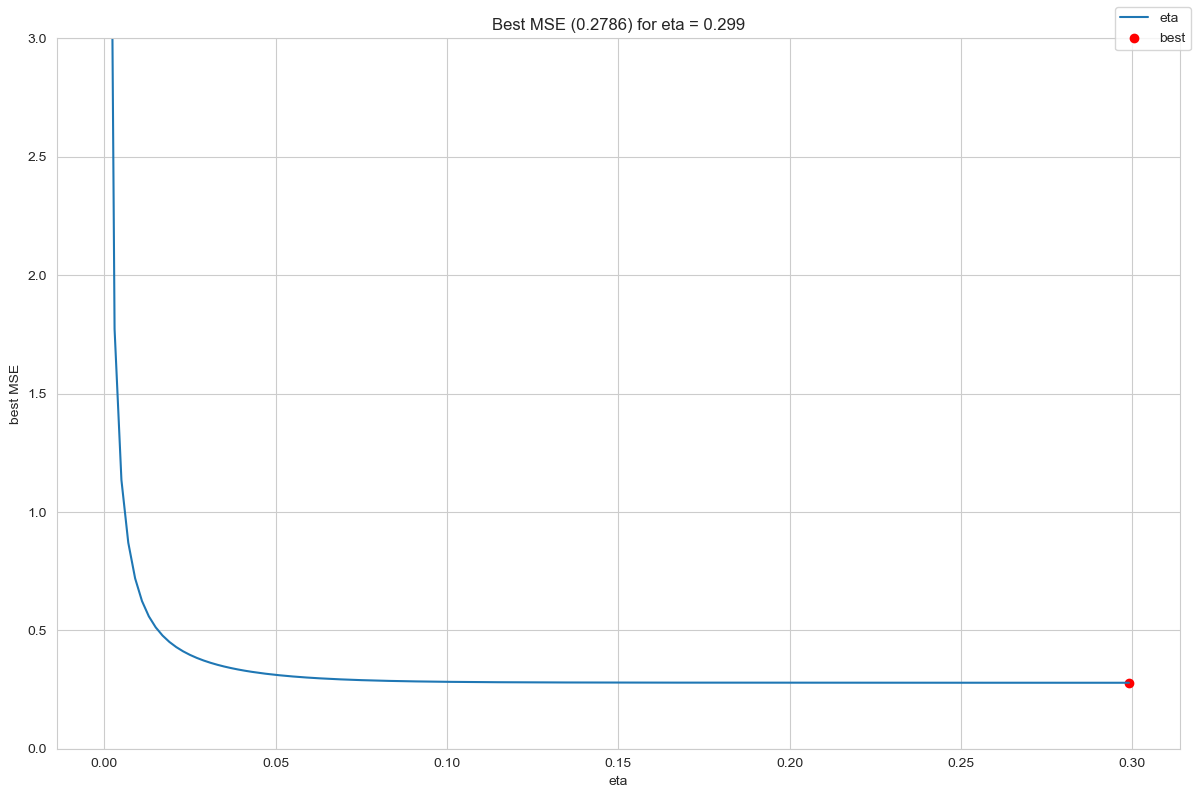

In [755]:
eta_x = [i for (i, _, _) in eta_logs]
eta_y = [i for (_, _, i) in eta_logs]
best_idx = np.argmin(eta_y)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eta_x, eta_y, label='eta')
ax.scatter(eta_x[best_idx], eta_y[best_idx], marker='o', label='best', color='r')
ax.set_xlabel('eta')
ax.set_ylabel('best MSE')
ax.set_title(f'Best MSE ({eta_y[best_idx]:.4}) for eta = {eta_x[best_idx]}')
ax.set_ylim([0, 3])
fig.legend()
fig.tight_layout()
plt.show()

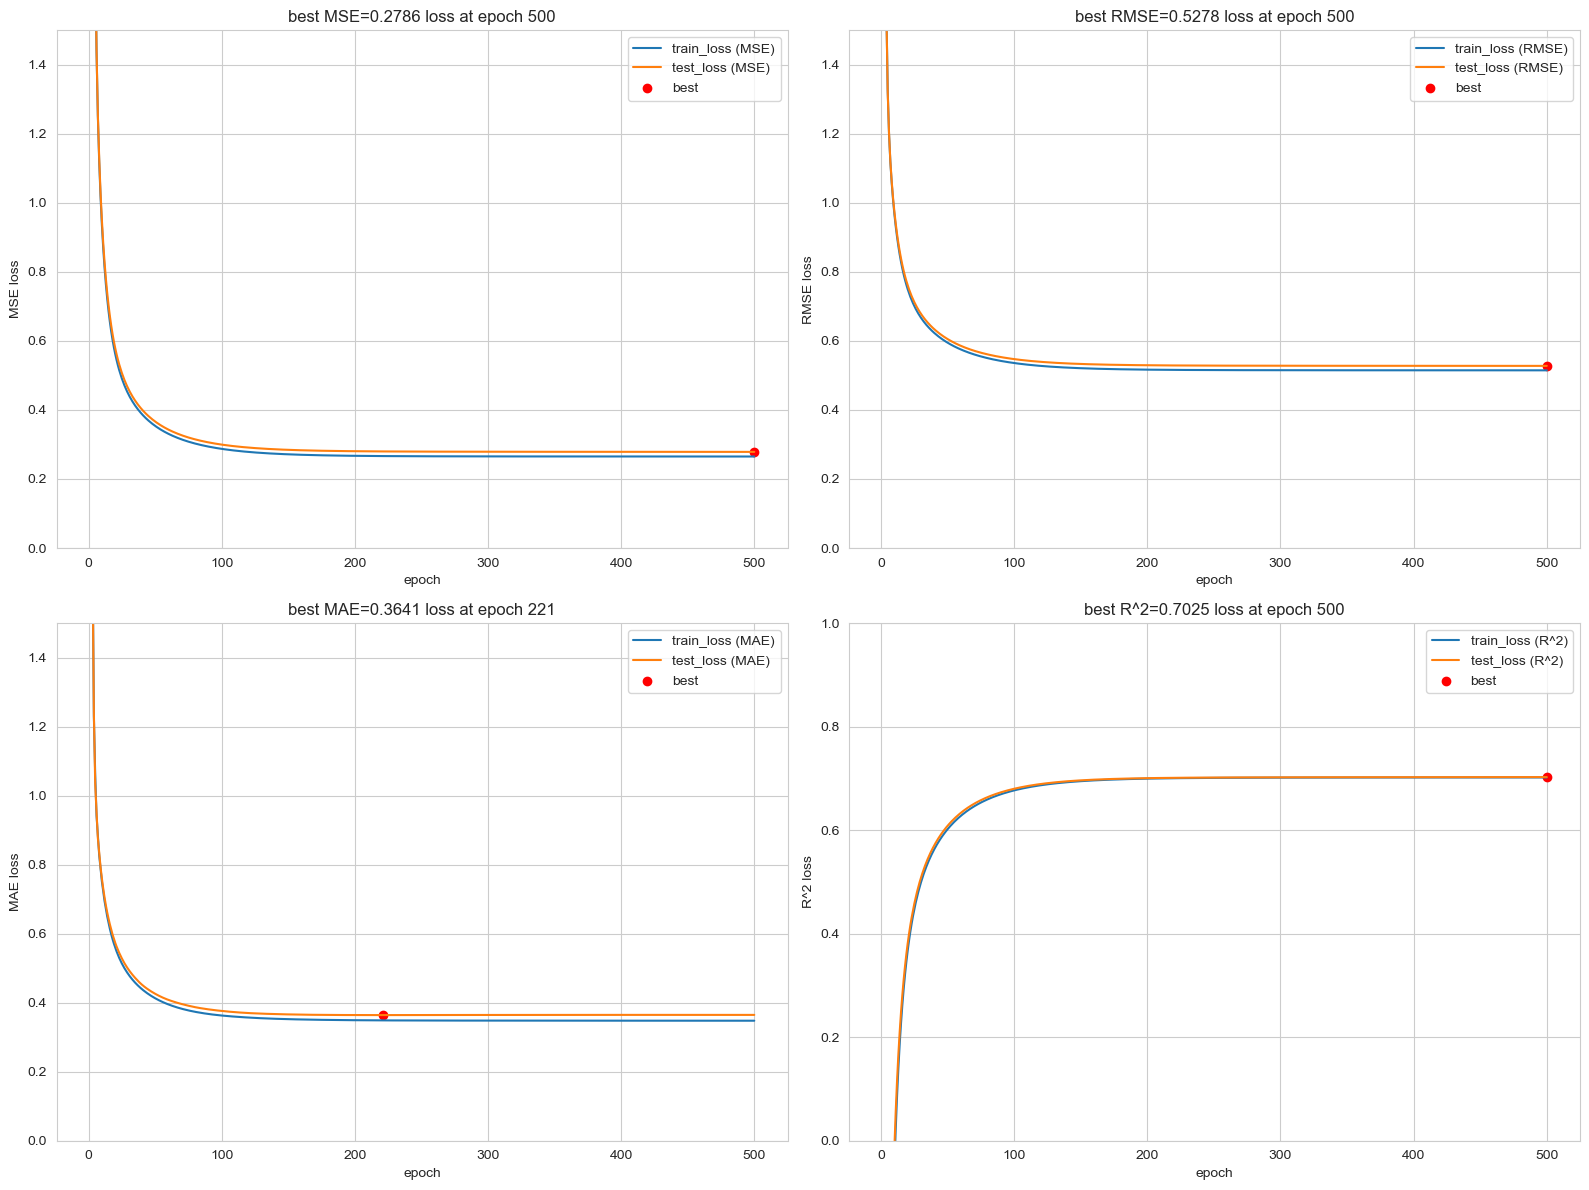

In [756]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

Let's do same for Mini-Batches!

In [757]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for i in range(1, 300, 2):
    eta = 0.001 * i
    print(f'eta: {eta}')
    logs = linear_regression(eta, data=X_train_reduced, test=X_test_reduced, y_train=y_train, y_test=y_test, n_epochs=500, batch_size=32)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

eta: 0.001
eta: 0.003
eta: 0.005
eta: 0.007
eta: 0.009000000000000001
eta: 0.011
eta: 0.013000000000000001
eta: 0.015
eta: 0.017
eta: 0.019
eta: 0.021
eta: 0.023
eta: 0.025
eta: 0.027
eta: 0.029
eta: 0.031
eta: 0.033
eta: 0.035
eta: 0.037
eta: 0.039
eta: 0.041
eta: 0.043000000000000003
eta: 0.045
eta: 0.047
eta: 0.049
eta: 0.051000000000000004
eta: 0.053
eta: 0.055
eta: 0.057
eta: 0.059000000000000004
eta: 0.061
eta: 0.063
eta: 0.065
eta: 0.067
eta: 0.069
eta: 0.07100000000000001
eta: 0.073
eta: 0.075
eta: 0.077
eta: 0.079
eta: 0.081
eta: 0.083
eta: 0.085
eta: 0.08700000000000001
eta: 0.089
eta: 0.091
eta: 0.093
eta: 0.095
eta: 0.097
eta: 0.099
eta: 0.101
eta: 0.10300000000000001
eta: 0.105
eta: 0.107
eta: 0.109
eta: 0.111
eta: 0.113
eta: 0.115
eta: 0.117
eta: 0.11900000000000001
eta: 0.121
eta: 0.123
eta: 0.125
eta: 0.127
eta: 0.129
eta: 0.131
eta: 0.133
eta: 0.135
eta: 0.137
eta: 0.139
eta: 0.14100000000000001
eta: 0.14300000000000002
eta: 0.145
eta: 0.147
eta: 0.149
eta: 0.151
eta: 

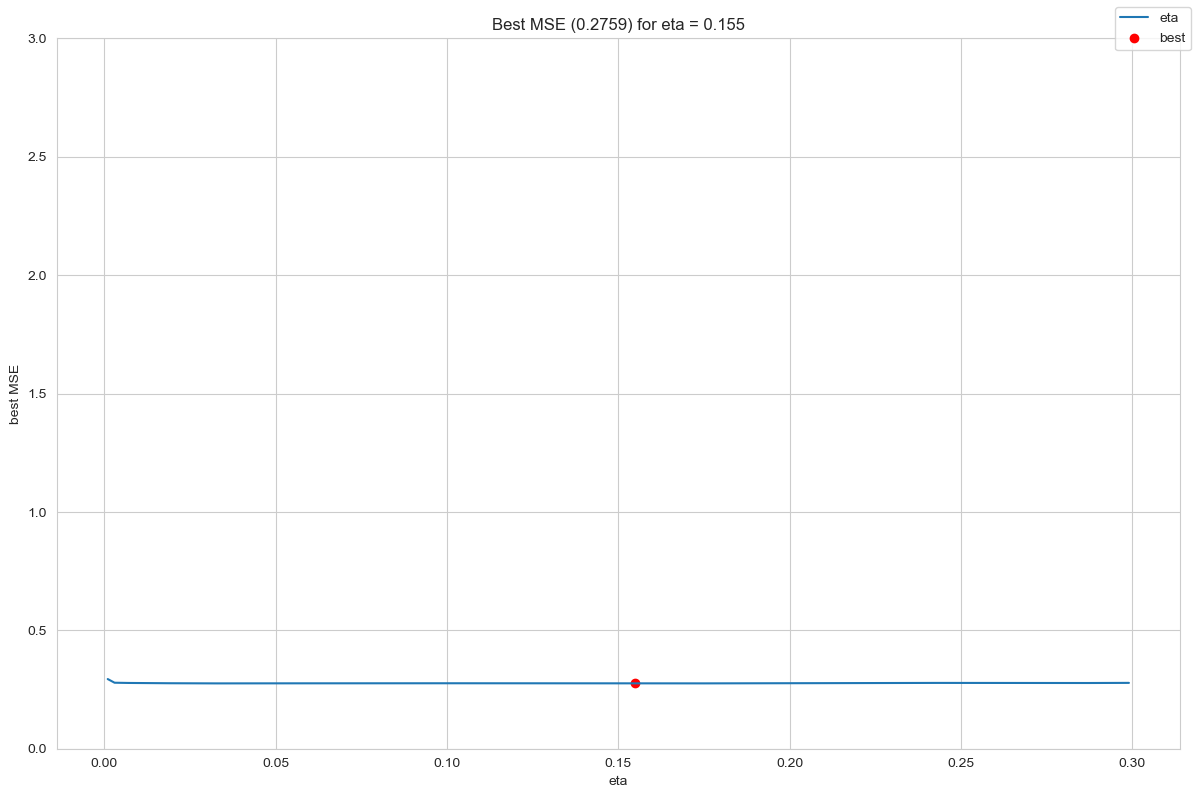

In [758]:
eta_x = [i for (i, _, _) in eta_logs]
eta_y = [i for (_, _, i) in eta_logs]
best_idx = np.argmin(eta_y)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eta_x, eta_y, label='eta')
ax.scatter(eta_x[best_idx], eta_y[best_idx], marker='o', label='best', color='r')
ax.set_xlabel('eta')
ax.set_ylabel('best MSE')
ax.set_title(f'Best MSE ({eta_y[best_idx]:.4}) for eta = {eta_x[best_idx]}')
ax.set_ylim([0, 3])
fig.legend()
fig.tight_layout()
plt.show()

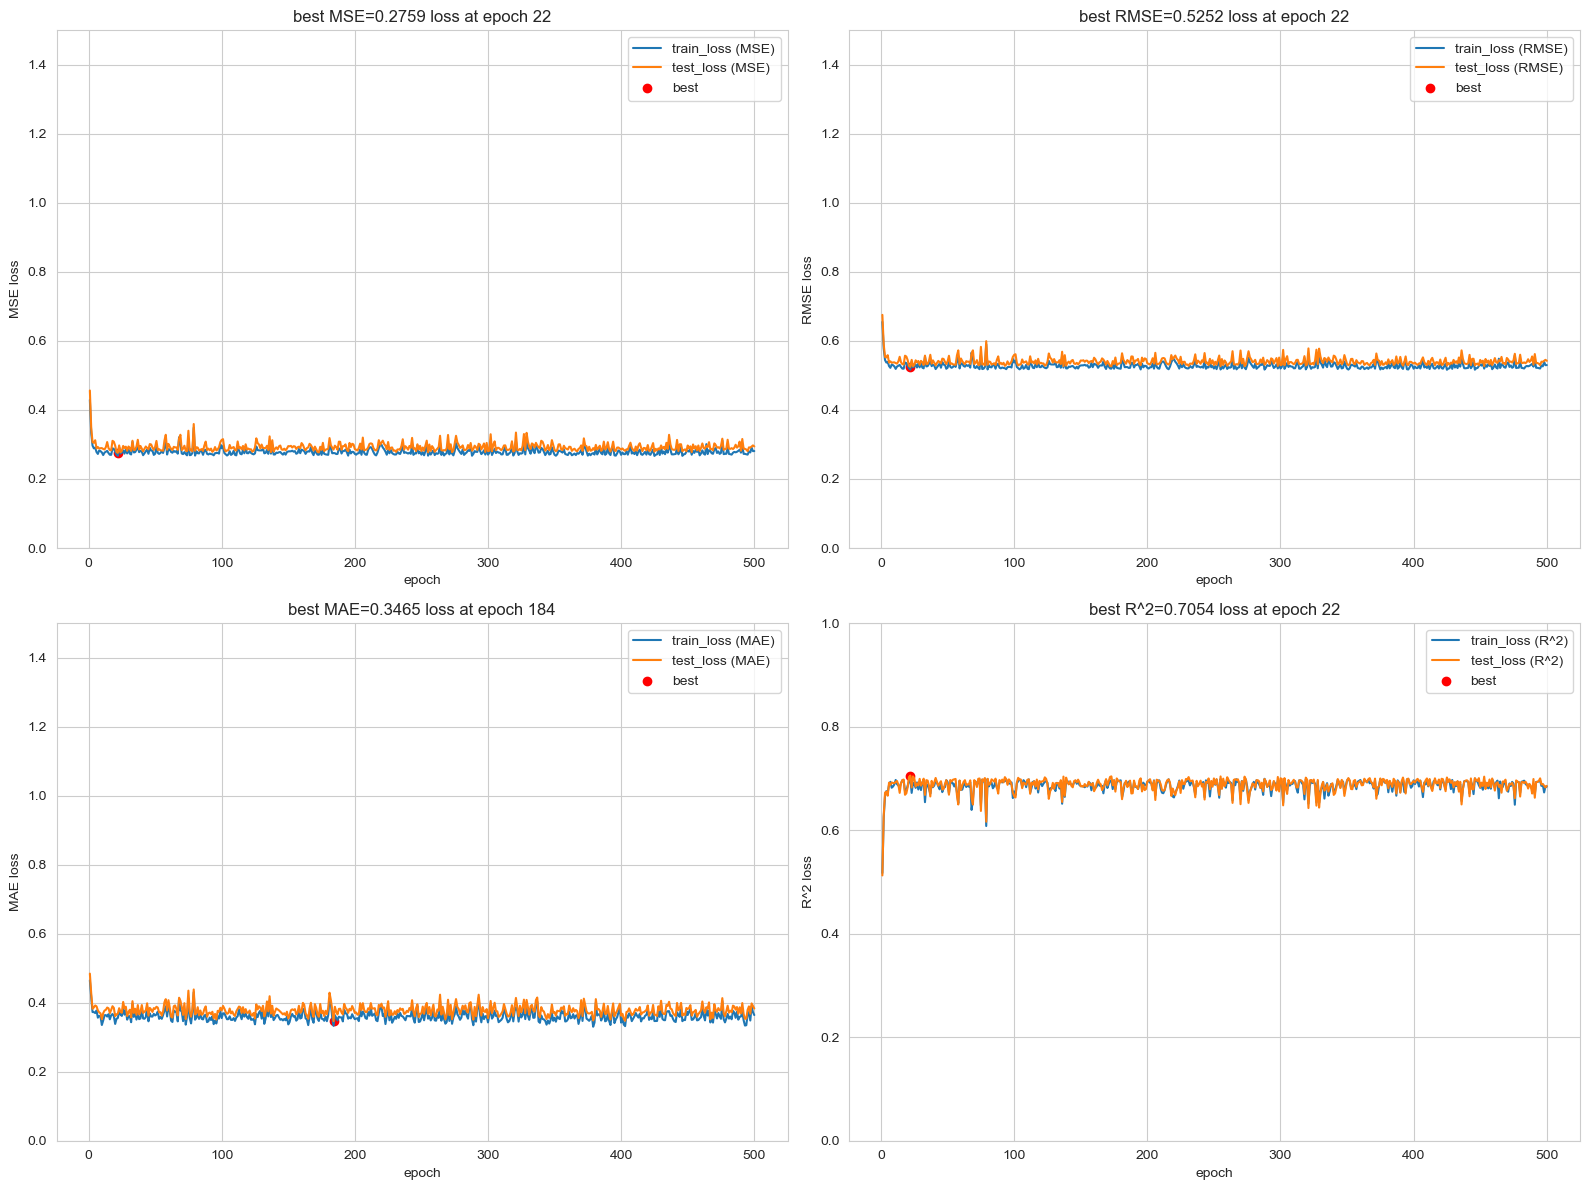

In [759]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

Now let's try with polynomial features

In [760]:
poly = sk.preprocessing.PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

In [761]:
#numeric_cols = X_train_reduced.columns
numeric_cols = ['age', 'bmi', 'children', 'stress_level']
numeric_cols

['age', 'bmi', 'children', 'stress_level']

In [762]:
Xtr_num = X_train_reduced[numeric_cols]
Xt_num = X_test_reduced[numeric_cols]

Xtr_poly = poly.fit_transform(Xtr_num)
Xte_poly  = poly.transform(Xt_num)

sc = sk.preprocessing.StandardScaler()
Xtr_poly = sc.fit_transform(Xtr_poly)
Xt_poly = sc.transform(Xte_poly)

In [763]:
X_train_augmented = X_train_reduced.drop(columns=numeric_cols)
X_test_augmented = X_test_reduced.drop(columns=numeric_cols)

X_train_augmented = pd.concat([X_train_augmented, pd.DataFrame(Xtr_poly, columns=poly.get_feature_names_out())],axis=1)
X_test_augmented = pd.concat([X_test_augmented, pd.DataFrame(Xte_poly, columns=poly.get_feature_names_out())], axis=1)

Now let's do the same with augs

In [764]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for i in range(1, 50, 1):
    eta = 0.01 * i
    print(f'eta: {eta}')
    logs = linear_regression(eta, data=X_train_augmented, test=X_test_augmented, y_train=y_train, y_test=y_test, n_epochs=500)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

eta: 0.01
eta: 0.02
eta: 0.03
eta: 0.04
eta: 0.05
eta: 0.06
eta: 0.07
eta: 0.08
eta: 0.09
eta: 0.1
eta: 0.11
eta: 0.12
eta: 0.13
eta: 0.14
eta: 0.15
eta: 0.16
eta: 0.17
eta: 0.18
eta: 0.19
eta: 0.2
eta: 0.21
eta: 0.22
eta: 0.23
eta: 0.24
eta: 0.25
eta: 0.26
eta: 0.27
eta: 0.28
eta: 0.29
eta: 0.3
eta: 0.31
eta: 0.32
eta: 0.33
eta: 0.34
eta: 0.35000000000000003
eta: 0.36
eta: 0.37
eta: 0.38
eta: 0.39
eta: 0.4
eta: 0.41000000000000003
eta: 0.42
eta: 0.43
eta: 0.44
eta: 0.45
eta: 0.46
eta: 0.47000000000000003
eta: 0.48
eta: 0.49


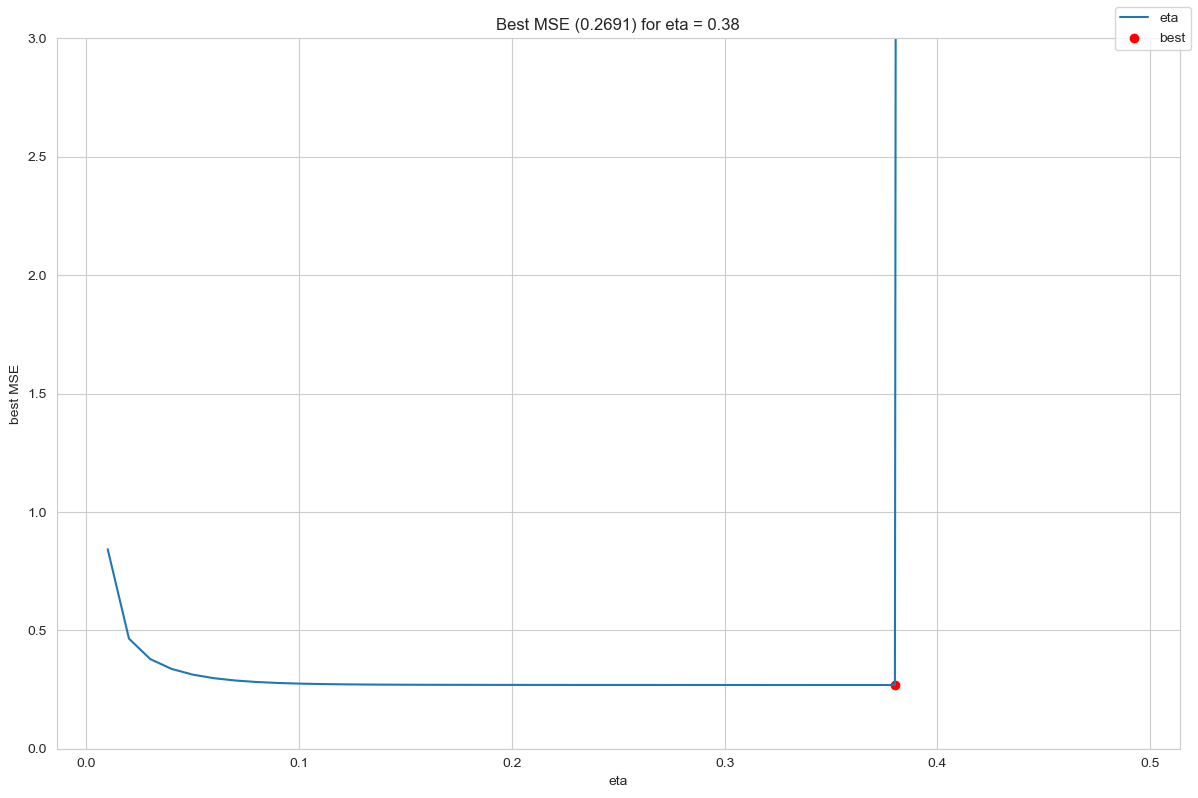

In [765]:
eta_x = [i for (i, _, _) in eta_logs]
eta_y = [i for (_, _, i) in eta_logs]
best_idx = np.argmin(eta_y)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eta_x, eta_y, label='eta')
ax.scatter(eta_x[best_idx], eta_y[best_idx], marker='o', label='best', color='r')
ax.set_xlabel('eta')
ax.set_ylabel('best MSE')
ax.set_title(f'Best MSE ({eta_y[best_idx]:.4}) for eta = {eta_x[best_idx]}')
ax.set_ylim([0, 3])
fig.legend()
fig.tight_layout()
plt.show()

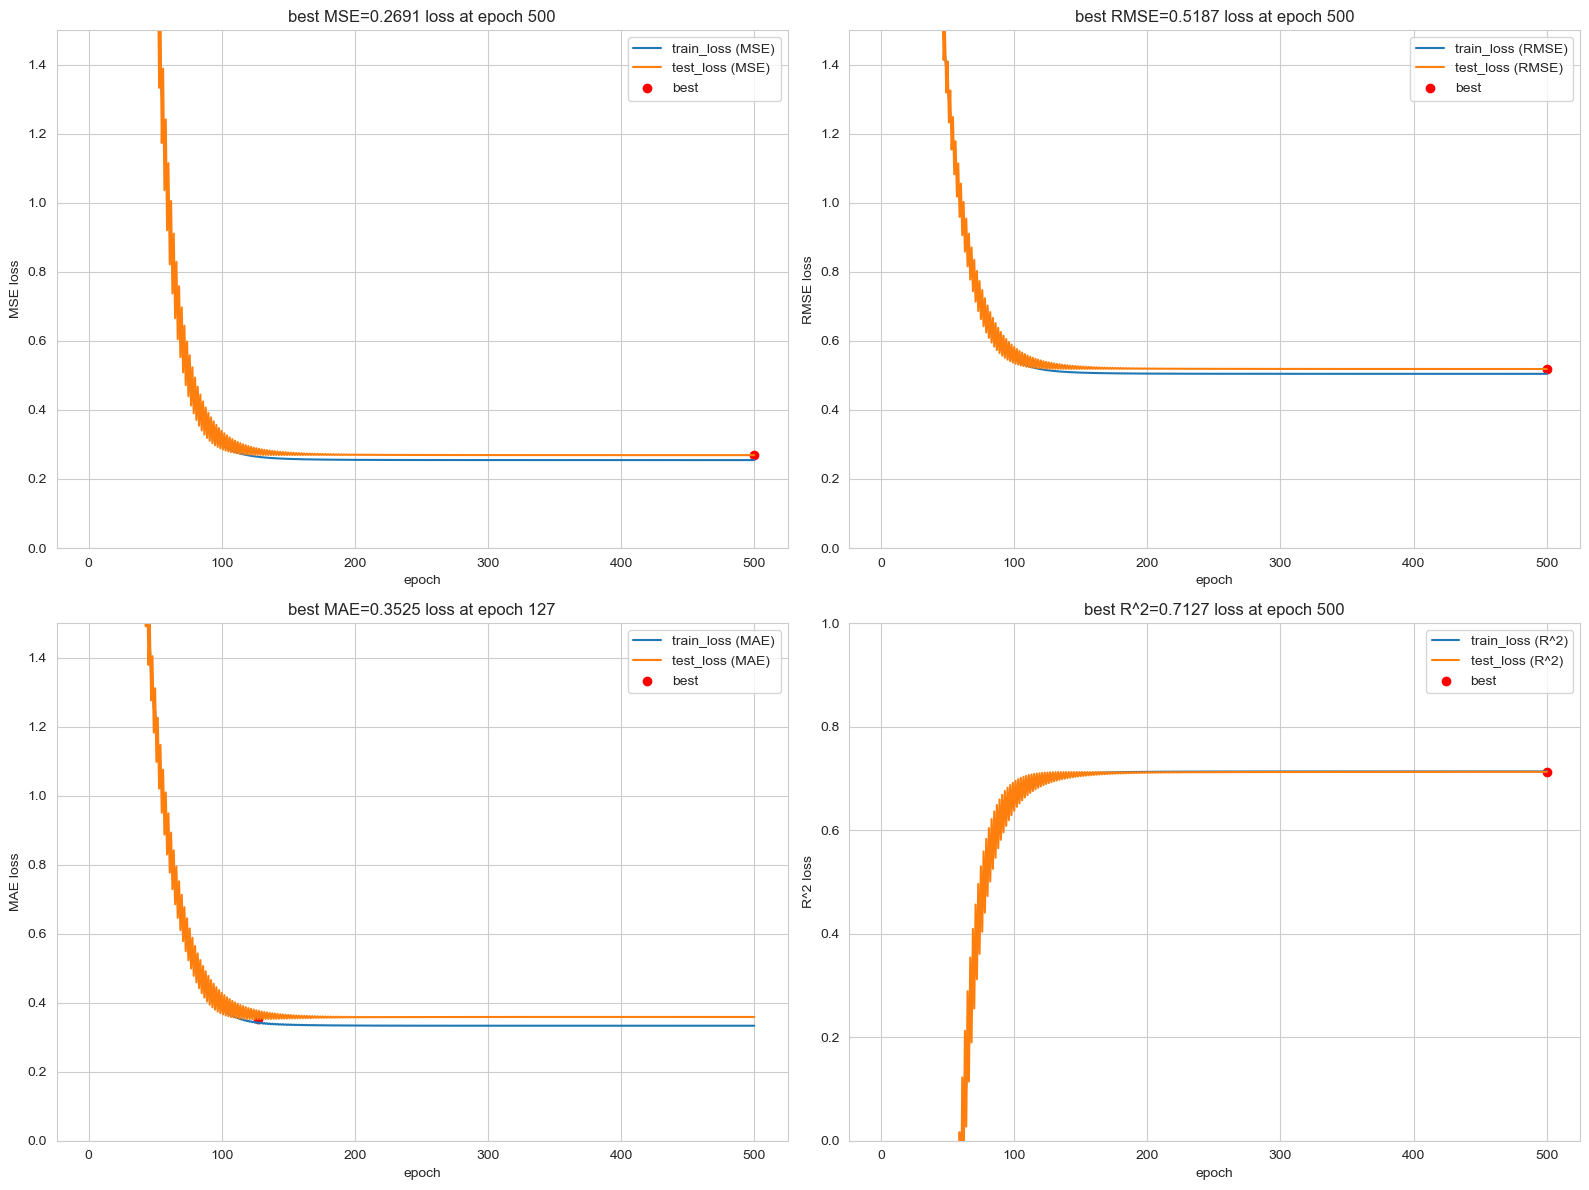

In [766]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

As we can see it takes much more time for a model to converge + we need smaller ETA (otherwise it's diverging)

Lasso (best_eta = 0.26)

In [767]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
best_alpha = None
alphas = [0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

for a in alphas:
    eta = 0.36
    print(f'alpha: {a}')
    logs = linear_regression(eta, data=X_train_augmented, test=X_test_augmented, y_train=y_train, y_test=y_test, n_epochs=500, lasso=True,
                             alpha=a)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs
        best_alpha = a

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

alpha: 0
alpha: 1e-05
alpha: 5e-05
alpha: 0.0001
alpha: 0.0005
alpha: 0.001
alpha: 0.005
alpha: 0.01
alpha: 0.05
alpha: 0.1
alpha: 0.5
alpha: 1


In [768]:
print(f'best alpha: {best_alpha}')
l = find_best_epoch(best_epoch_logs)
l.theta

best alpha: 0


[7.359693003044149,
 0.666590449667113,
 -0.017610751399586257,
 -0.06081641646934473,
 0.0072318308998207915,
 -0.03225358798233492,
 -0.02910326956853638,
 1.4743901993771442,
 1.840930733878398,
 1.4354813844066412,
 1.9974839030689326,
 0.01572792187976743,
 0.6528846332238878,
 0.6240150520736903,
 -0.09021900065170992,
 -0.12007879444024613,
 0.7600118626493667,
 0.5516663623334598,
 0.5919265679208796,
 -0.11934082828920245,
 0.19798992281191774,
 0.20501358432485997,
 0.04507036249764973,
 -0.063392625697218,
 0.4148199581466903,
 0.03296049072747515,
 0.06574114521208257,
 0.04290193190971578,
 -0.05681472891048869,
 -0.003721676043763768,
 -0.07136931765461693,
 -0.01988669944524184,
 -0.017979320059962816,
 -0.015422717164060368,
 0.00787944305745053,
 -0.02372084582745827,
 -0.010888806362692937,
 0.0054354789354247686]

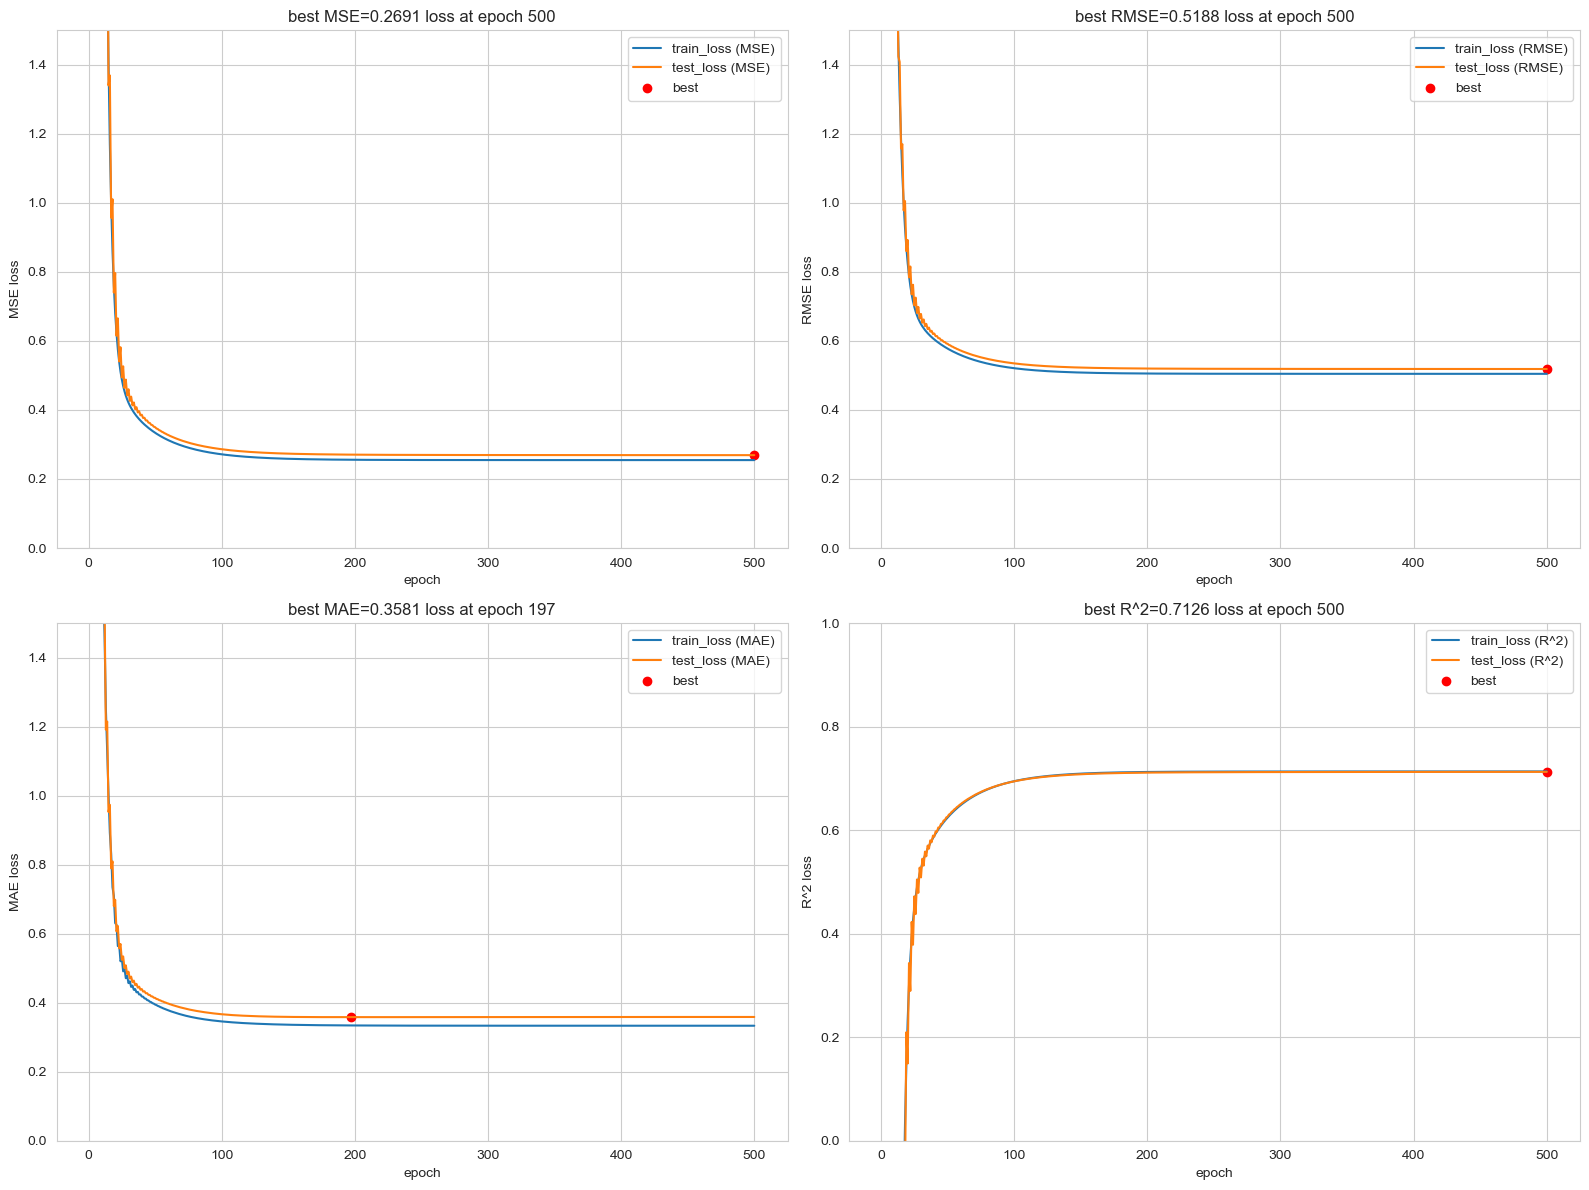

In [769]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

In [770]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for a in alphas:
    eta = 0.36
    print(f'alpha: {a}')
    logs = linear_regression(eta, data=X_train_augmented, test=X_test_augmented, y_train=y_train, y_test=y_test, n_epochs=500, ridge=True,
                             alpha=a)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs
        best_alpha = a

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

alpha: 0
alpha: 1e-05
alpha: 5e-05
alpha: 0.0001
alpha: 0.0005
alpha: 0.001
alpha: 0.005
alpha: 0.01
alpha: 0.05
alpha: 0.1
alpha: 0.5
alpha: 1


In [771]:
print(f'best alpha: {best_alpha}')
l = find_best_epoch(best_epoch_logs)
l.theta

best alpha: 0


[7.359693003044149,
 0.666590449667113,
 -0.017610751399586257,
 -0.06081641646934473,
 0.0072318308998207915,
 -0.03225358798233492,
 -0.02910326956853638,
 1.4743901993771442,
 1.840930733878398,
 1.4354813844066412,
 1.9974839030689326,
 0.01572792187976743,
 0.6528846332238878,
 0.6240150520736903,
 -0.09021900065170992,
 -0.12007879444024613,
 0.7600118626493667,
 0.5516663623334598,
 0.5919265679208796,
 -0.11934082828920245,
 0.19798992281191774,
 0.20501358432485997,
 0.04507036249764973,
 -0.063392625697218,
 0.4148199581466903,
 0.03296049072747515,
 0.06574114521208257,
 0.04290193190971578,
 -0.05681472891048869,
 -0.003721676043763768,
 -0.07136931765461693,
 -0.01988669944524184,
 -0.017979320059962816,
 -0.015422717164060368,
 0.00787944305745053,
 -0.02372084582745827,
 -0.010888806362692937,
 0.0054354789354247686]

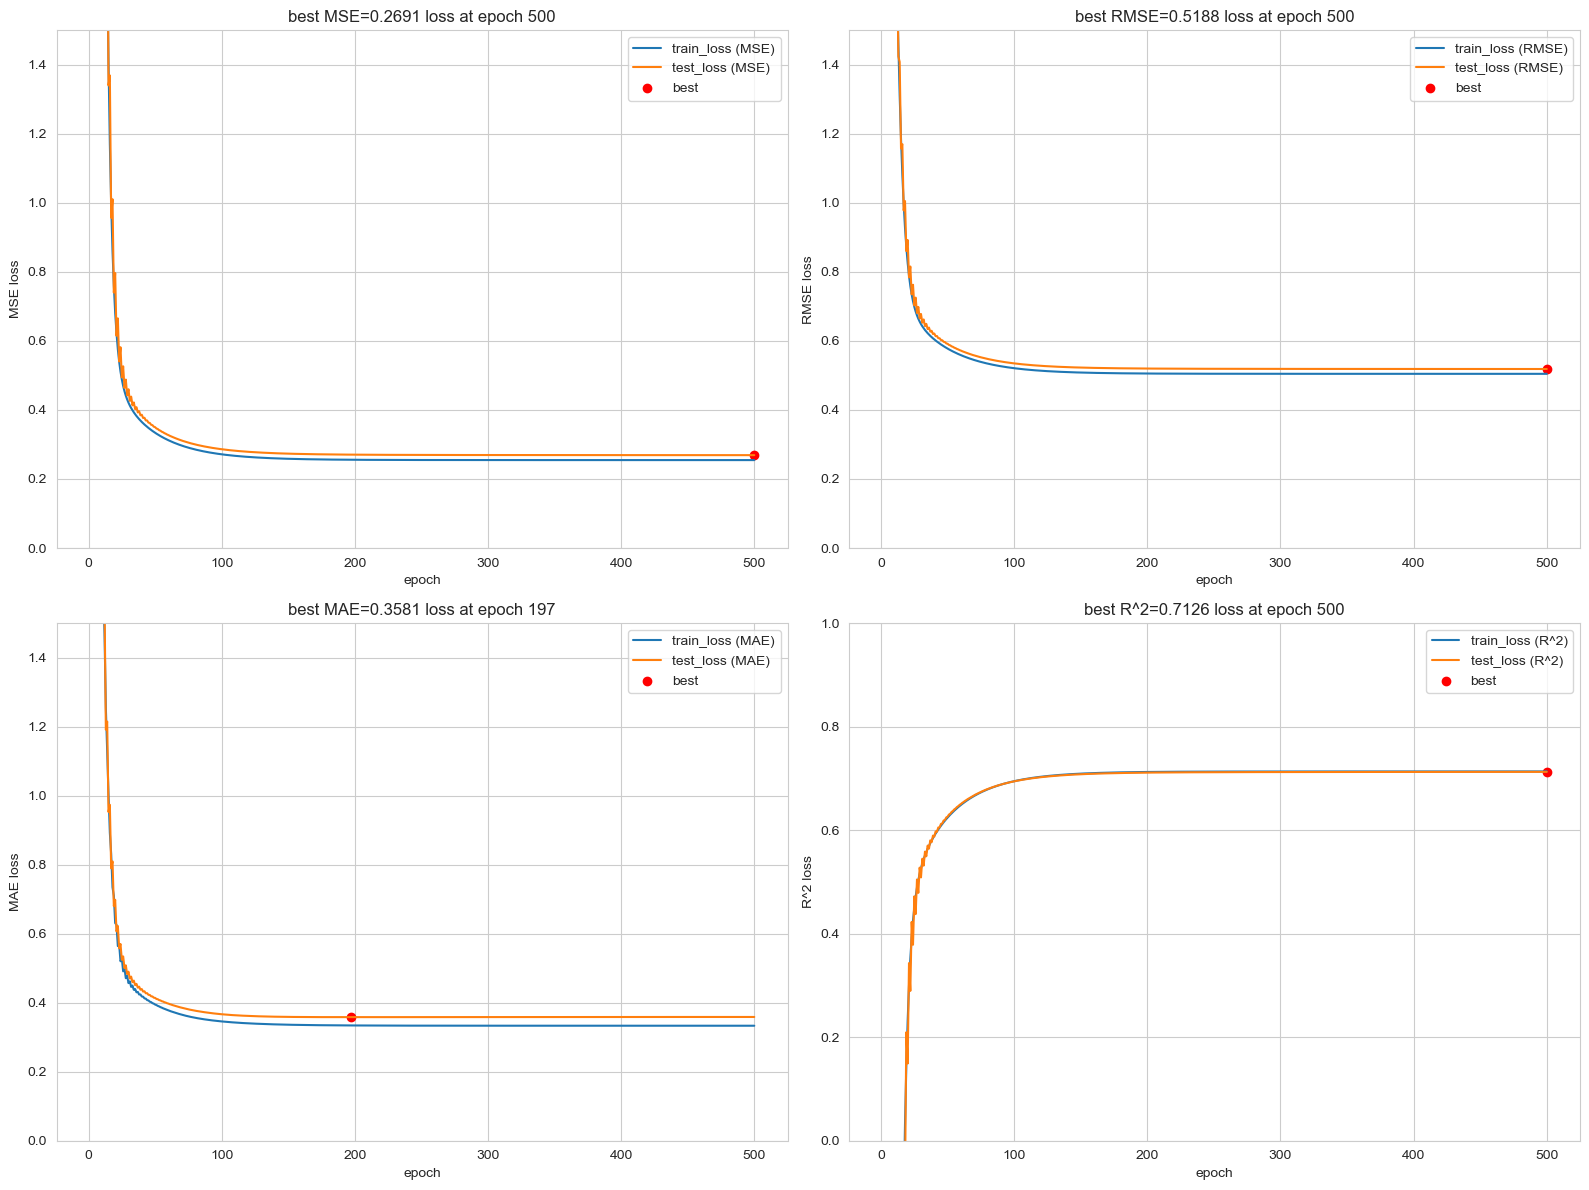

In [772]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

In [773]:
tmp_df = pd.concat([pd.concat([X_train_reduced, X_test_reduced], ignore_index=True),
                     pd.concat([y_train, y_test], ignore_index=True).rename('target')],
                    axis=1)

male_df   = tmp_df[tmp_df['is_male'] == 1]
female_df = tmp_df[tmp_df['is_male'] == 0]

X_train_m, X_test_m, y_train_m, y_test_m = sk.model_selection.train_test_split(
    male_df.drop(columns='target'),
    male_df['target'],
    test_size=0.3,
    random_state=seed,
    shuffle=True
)
X_train_f, X_test_f, y_train_f, y_test_f = sk.model_selection.train_test_split(
    female_df.drop(columns='target'),
    female_df['target'],
    test_size=0.3,
    random_state=seed,
    shuffle=True
)

In [774]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for i in range(1, 300, 5):
    eta = 0.001 * i
    print(f'eta: {eta}')
    logs = linear_regression(eta, data=X_train_m, test=X_test_m, y_train=y_train_m, y_test=y_test_m, n_epochs=500, batch_size=64)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

eta: 0.001
eta: 0.006
eta: 0.011
eta: 0.016
eta: 0.021
eta: 0.026000000000000002
eta: 0.031
eta: 0.036000000000000004
eta: 0.041
eta: 0.046
eta: 0.051000000000000004
eta: 0.056
eta: 0.061
eta: 0.066
eta: 0.07100000000000001
eta: 0.076
eta: 0.081
eta: 0.08600000000000001
eta: 0.091
eta: 0.096
eta: 0.101
eta: 0.106
eta: 0.111
eta: 0.116
eta: 0.121
eta: 0.126
eta: 0.131
eta: 0.136
eta: 0.14100000000000001
eta: 0.146
eta: 0.151
eta: 0.156
eta: 0.161
eta: 0.166
eta: 0.171
eta: 0.176
eta: 0.181
eta: 0.186
eta: 0.191
eta: 0.196
eta: 0.201
eta: 0.20600000000000002
eta: 0.211
eta: 0.216
eta: 0.221
eta: 0.226
eta: 0.231
eta: 0.23600000000000002
eta: 0.241
eta: 0.246
eta: 0.251
eta: 0.256
eta: 0.261
eta: 0.266
eta: 0.271
eta: 0.276
eta: 0.281
eta: 0.28600000000000003
eta: 0.291
eta: 0.296


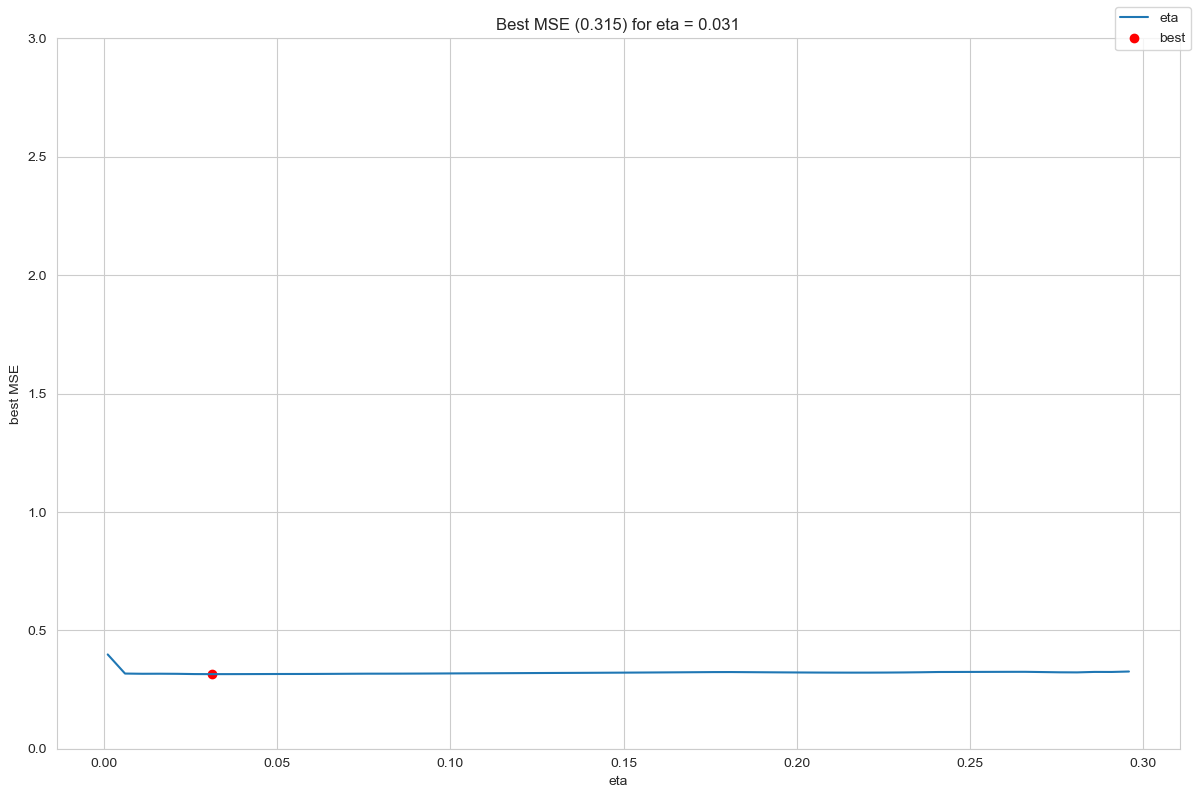

In [775]:
eta_x = [i for (i, _, _) in eta_logs]
eta_y = [i for (_, _, i) in eta_logs]
best_idx = np.argmin(eta_y)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eta_x, eta_y, label='eta')
ax.scatter(eta_x[best_idx], eta_y[best_idx], marker='o', label='best', color='r')
ax.set_xlabel('eta')
ax.set_ylabel('best MSE')
ax.set_title(f'Best MSE ({eta_y[best_idx]:.4}) for eta = {eta_x[best_idx]}')
ax.set_ylim([0, 3])
fig.legend()
fig.tight_layout()
plt.show()

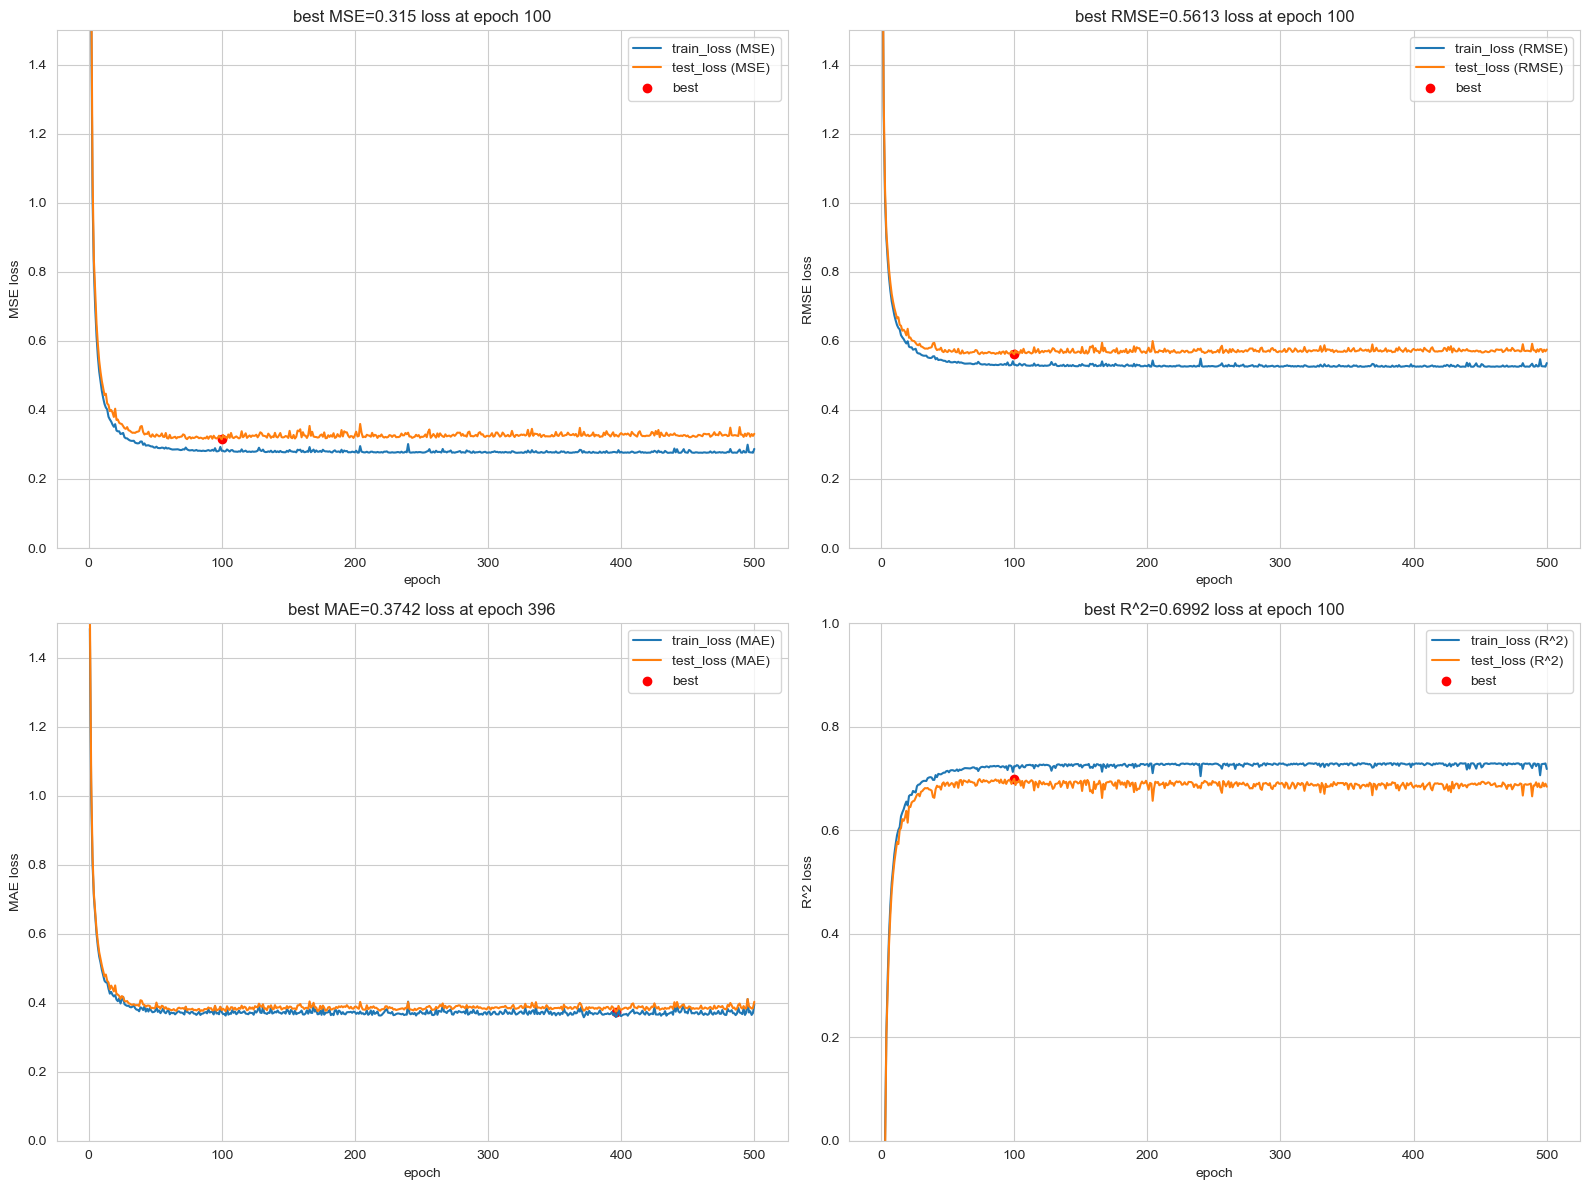

In [776]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()

In [777]:
eta_logs = []
best_epoch_logs = None
best_eta_loss = float('inf')
for i in range(1, 300, 5):
    eta = 0.001 * i
    print(f'eta: {eta}')
    logs = linear_regression(eta, data=X_train_f, test=X_test_f, y_train=y_train_f, y_test=y_test_f, n_epochs=500, batch_size=64)
    ans = find_best_epoch(logs)
    if ans.test_losses[0] < best_eta_loss:
        best_eta_loss = ans.test_losses[0]
        best_epoch_logs = logs

    eta_logs.append((eta, ans.train_losses[0], ans.test_losses[0]))

eta: 0.001
eta: 0.006
eta: 0.011
eta: 0.016
eta: 0.021
eta: 0.026000000000000002
eta: 0.031
eta: 0.036000000000000004
eta: 0.041
eta: 0.046
eta: 0.051000000000000004
eta: 0.056
eta: 0.061
eta: 0.066
eta: 0.07100000000000001
eta: 0.076
eta: 0.081
eta: 0.08600000000000001
eta: 0.091
eta: 0.096
eta: 0.101
eta: 0.106
eta: 0.111
eta: 0.116
eta: 0.121
eta: 0.126
eta: 0.131
eta: 0.136
eta: 0.14100000000000001
eta: 0.146
eta: 0.151
eta: 0.156
eta: 0.161
eta: 0.166
eta: 0.171
eta: 0.176
eta: 0.181
eta: 0.186
eta: 0.191
eta: 0.196
eta: 0.201
eta: 0.20600000000000002
eta: 0.211
eta: 0.216
eta: 0.221
eta: 0.226
eta: 0.231
eta: 0.23600000000000002
eta: 0.241
eta: 0.246
eta: 0.251
eta: 0.256
eta: 0.261
eta: 0.266
eta: 0.271
eta: 0.276
eta: 0.281
eta: 0.28600000000000003
eta: 0.291
eta: 0.296


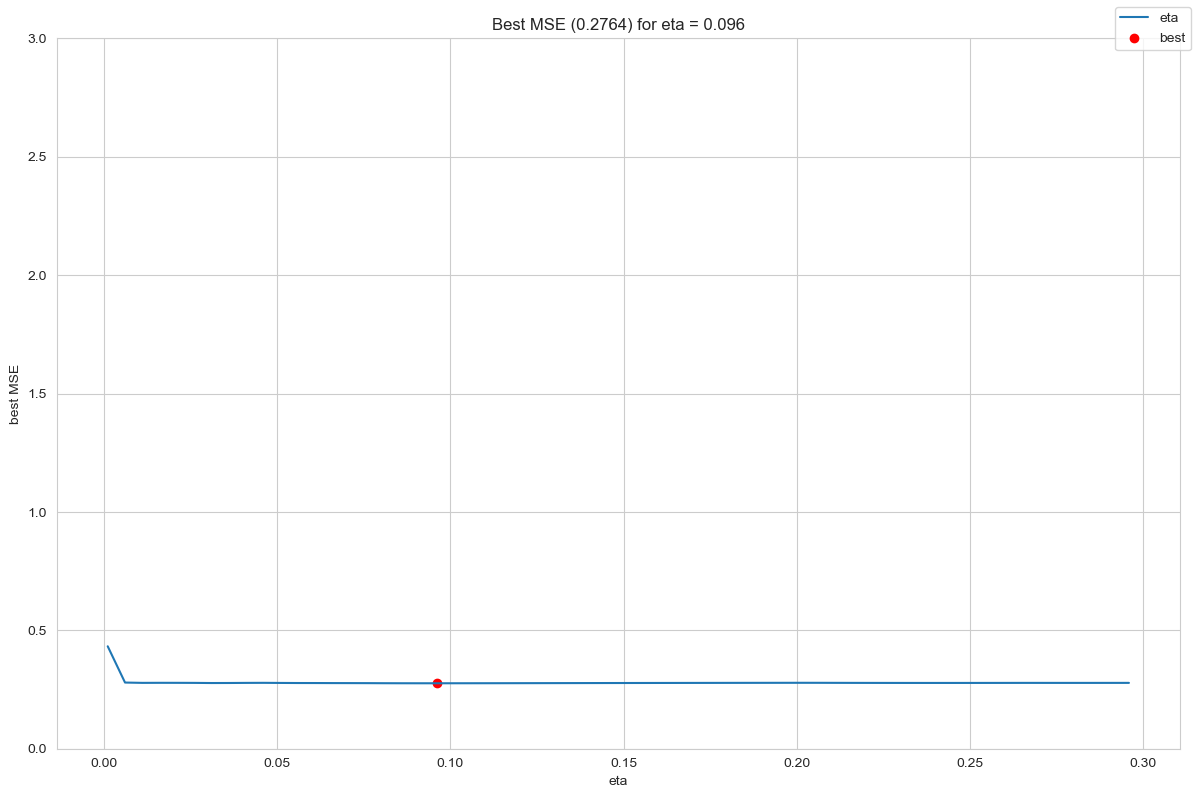

In [778]:
eta_x = [i for (i, _, _) in eta_logs]
eta_y = [i for (_, _, i) in eta_logs]
best_idx = np.argmin(eta_y)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eta_x, eta_y, label='eta')
ax.scatter(eta_x[best_idx], eta_y[best_idx], marker='o', label='best', color='r')
ax.set_xlabel('eta')
ax.set_ylabel('best MSE')
ax.set_title(f'Best MSE ({eta_y[best_idx]:.4}) for eta = {eta_x[best_idx]}')
ax.set_ylim([0, 3])
fig.legend()
fig.tight_layout()
plt.show()

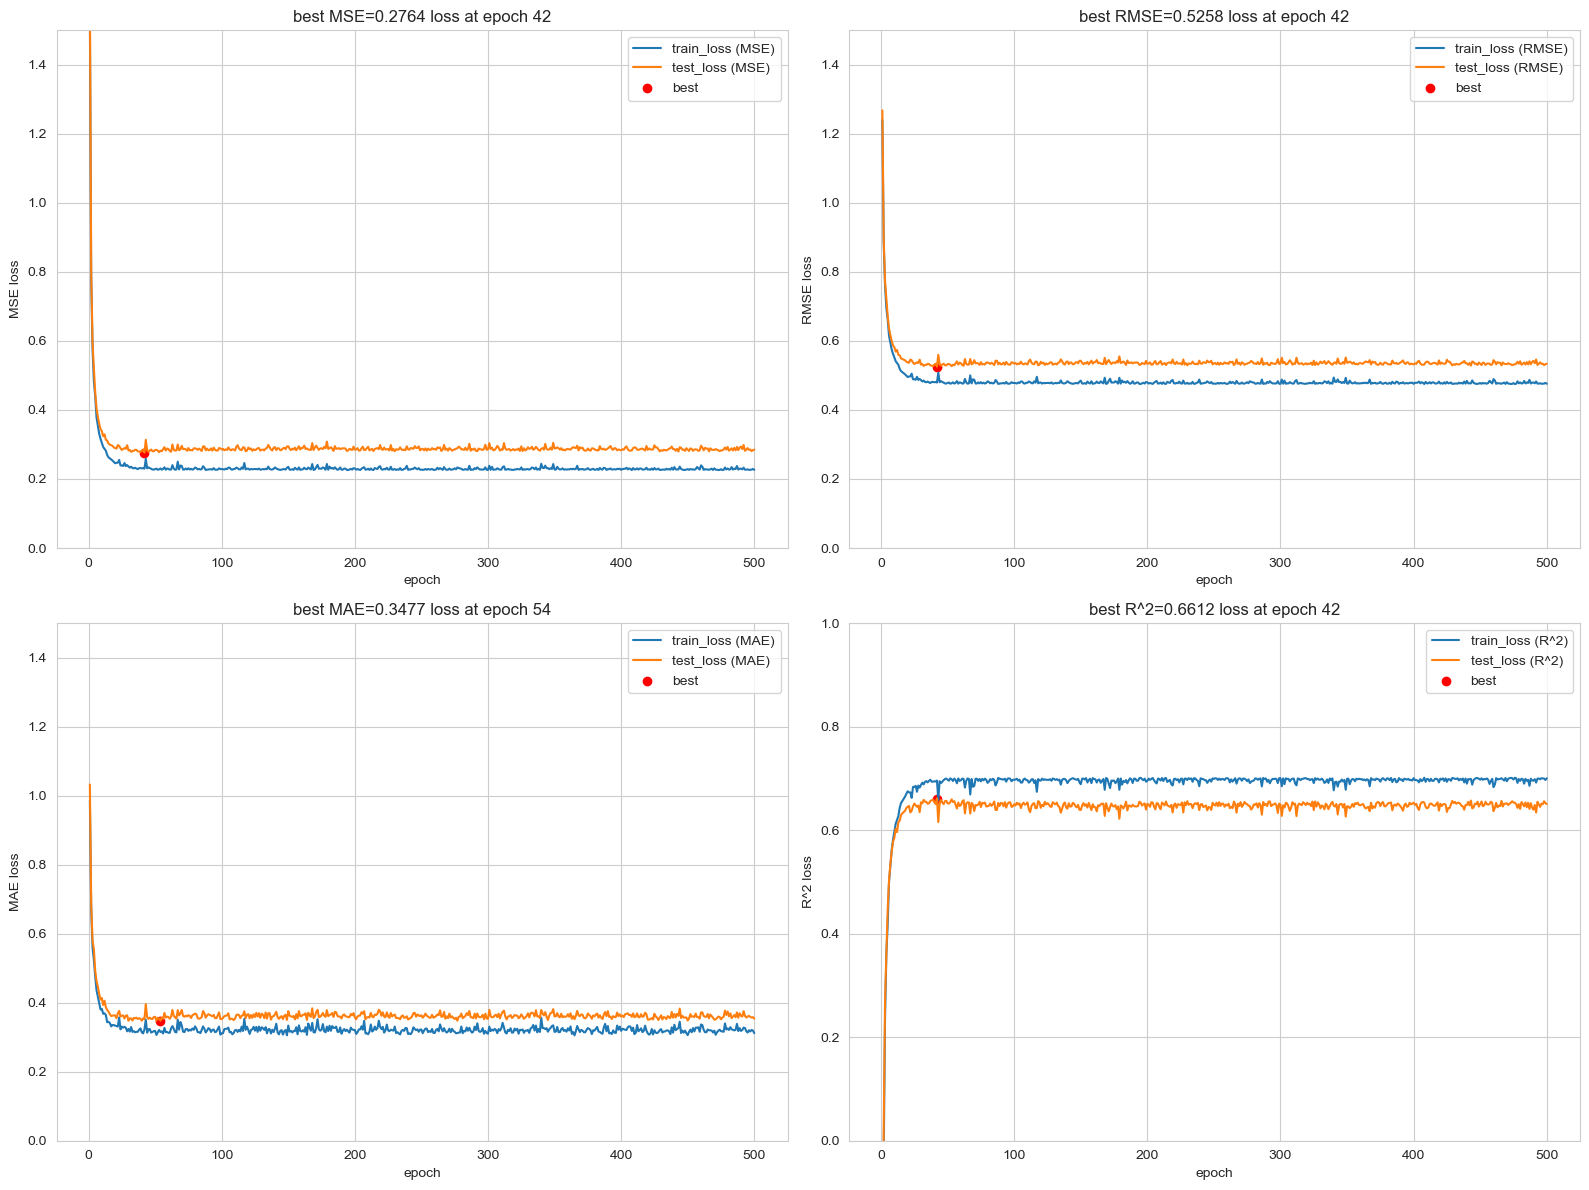

In [779]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
labels = ['MSE', 'RMSE', 'MAE', 'R^2']
lims = [
    [0, 1.5],
    [0, 1.5],
    [0, 1.5],
    [0, 1]
]

for i in range(2):
    for j in range(2):
        epoch_x = [i.epoch for i in best_epoch_logs]
        l = labels[i*2+j]
        epoch_y_tr = [k.train_losses[i*2+j] for k in best_epoch_logs]
        epoch_y_t = [k.test_losses[i*2+j] for k in best_epoch_logs]
        best_idx = np.argmin(epoch_y_t) if i*2+j != 3 else np.argmax(epoch_y_t)

        axes[i][j].plot(epoch_x, epoch_y_tr, label=f'train_loss ({l})')
        axes[i][j].plot(epoch_x, epoch_y_t, label=f'test_loss ({l})')
        axes[i][j].scatter(epoch_x[best_idx], epoch_y_t[best_idx], marker='o', label='best', color='r')
        axes[i][j].set_title(f'best {l}={epoch_y_t[best_idx]:.4} loss at epoch {epoch_x[best_idx]}')
        axes[i][j].set_xlabel('epoch')
        axes[i][j].set_ylabel(f'{l} loss')
        axes[i][j].set_ylim(lims[i*2+j])
        axes[i][j].legend()

fig.tight_layout()
plt.show()